# Assignment #8

In order to automate the process of reviewing customer call and complaint logs to identify critical customer messages, my Data Science team recommends a language model to classify customer reviews. Specifically, my team recommends the use of a Recurrent Neural Network (RNN) trained in a supervised fashion to identify sentiment analysis of written customer reviews to automate this task with a high degree of prediction accuracy. We believe an RNN architecture consisting of bidirectional LSTM or GRU cells coupled with fully connected layers will optimize the predictive performance and allow customer service representatives to accurately and efficiently identify disgruntled customers and remedy their experience with our products and company.

These recommendations are based on the results of a recent factorial study my team conducted looking into the ability of RNNs to predict whether or not a tweet was referencing a natural disaster. The RNN architecture my team evaluated consisted of an Embedding layer, two bidirectional LSTM cells, one Dense layer, a Dropout layer, and a last Dense layer for output. This model was compiled with the Adam optimizer and a learning rate of 0.0001. The Embedding layer in this architecture served the critical function of mapping incoming twitter data to pre-trained word vectors providing meaningful numeric data the RNN could take in to find patterns. The factors my team evaluated in this study were the neural network embedding types (word vectors) and the vocabulary size. The function of the word vectors is to relate each word from our tweets, or customer complaints, to a numeric vector in a high-dimensional space so patterns can be found between like words. The vocabulary size limits our model to how many words it will recognize and therefore map to one of these word vectors. For example, we can set our vocabulary to the top 10,000 words in English or to the top 1,000,000 words in English. Once this limit is set, only these top words will be translated into numeric vectors while the 10,001st or 1,000,001st words will simply be represented as a vector of 0s. This study evaluated the GloVe.6B.50d and GloVe.Twitter.27B.50d embeddings with vocabulary sizes of 10,000 and 100,000 words. 

In order to make use of RNNs, significant data preprocessing and exploration is needed. For example, in our experiment outlined above my team first needed to download and extract the embeddings we were to use for this study. Then, the raw twitter data had to be loaded into our program, reviewed to verify data types, and counted to get an understanding of how many tweets we were working with. Our team visualized the breakdown of Non-Disaster and Disaster labels in our training data revealing there were more Non-Disaster than Disaster tweets. This ensured the team would stratify our full training dataset upon splitting into a training and validation set. Each tweet was broken down into individual words which were mapped to a unique numerical index and then padded to ensure all tweets were of the same length. Lastly, an embedding matrix was created in order to link each word index to its corresponding pre-trained word vector.

Once our RNN was defined and data was properly processed, the study was executed. Each cell of our factorial design was evaluated for its model training speed, training set accuracy, validation set accuracy, and F1 score on the test data predictions. The team found that the embedding type and vocabulary sizes evaluated had limited impact on the model processing speed. The average processing time was 30.3 seconds. It was determined that the two factors did have an impact on classification performance. The GloVe.Twitter.27B.50d embedding outperformed the GloVe.6B.60d embedding while increasing the vocabulary size also improved the F1 score for this application. 

Guided by these learnings, my team recommends using domain specific pre-trained word vectors while building a language model for classifying sentiment analysis from customer reports. Additionally, it will be important to leverage a high vocabulary so the maximum amount of learning can be distilled from each customer log. It will be critical for my Data Science team to engineer a suitable pipeline to pre-process all customer log data. For instance, we will want to eliminate stop words and other low value, high frequency words from the input data to our RNN model prior to training and making predictions. The team will not only build the model, but also deploy it to enable a functional user interface for customer service reps to use independently. The team also recommends investments in increased CPU, RAM, and GPU hardware capabilities to support this model. Especially since this team recommends utilizing word vectors in higher dimensional spaces such as 200-300 Dimensional space allowing for increased degrees of freedom for pattern recognition and improved model performance.


## Load Libraries

In [1]:
#Set Runtime Type in Colab to run GPU

In [2]:
!pip install scikit-plot

In [3]:
!pip install chakin

In [4]:
#Load in useful libraries and packages:
%matplotlib inline
import matplotlib.pyplot as plt  
import numpy as np               
import os
import pandas as pd  
import seaborn as sns 
import math
import re
from datetime import datetime
import sklearn
from sklearn.model_selection import train_test_split
from scipy import stats
import scikitplot as skplt
import shutil
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import nltk # Natural Language Toolkit
from nltk.tokenize import TreebankWordTokenizer #tokenize text
import time # Record processing time
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, GRU, SimpleRNN, LSTM
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [5]:
#Now load in tensorflow and keras
import tensorflow as tf
from tensorflow import keras
import io

In [6]:
#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
#Python chakin package install
import chakin
import json
from collections import defaultdict

## Set Working Directory

In [8]:
#Set working directory
from google.colab import drive 
drive.mount('/content/drive')
os.getcwd()

Mounted at /content/drive


'/content'

In [9]:
#Data is loaded into the DisasterTweets directory:
%cd /content/drive/MyDrive/MSDS 422 - ML/DisasterTweets/
%ls

/content/drive/MyDrive/MSDS 422 - ML/DisasterTweets
glove.6B/            glove_extract/  twitter/            twitter_ALL.csv
glove6B_100,000.csv  test.csv        twitter_10,000.csv  twitter_extract/
glove6B_10000.csv    train.csv       twitter_100K.csv


In [10]:
#Verify in the correct working directory:
print("Current Working Directory:")
print(os.getcwd())

Current Working Directory:
/content/drive/MyDrive/MSDS 422 - ML/DisasterTweets


## Load Data and EDA

In [11]:
#Read in .csv files as a pandas DataFrame:
df_train = pd.read_csv("train.csv")
df_train.head()

id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]

I can see here that the dataframe has been loaded in. All Tweets are in the 'text' column and the label is in the 'target' column.

In [12]:
#Read in the test .csv
df_test = pd.read_csv("test.csv")
df_test.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

I can see that the test dataset has the 'text' column with the tweets, but no target column as that is what I will try to predict with the RNN.

I want to better understand this data so will look at the DataFrame info:

In [13]:
#Look at the Pandas DataFrame training data info:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [14]:
#Now look at the test data info:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


From this, it can be seen that there are 7,613 trainin instances and 3,263 test instances. In total, 10,876 tweets will be processed during this exercise.

0    4342
1    3271
Name: target, dtype: int64


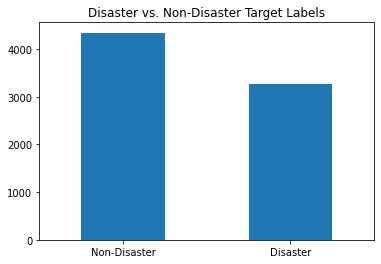

In [15]:
#Take a look at distribution of Disaster vs. Non-Disaster Tweets:
print(df_train['target'].value_counts())
df_train['target'].value_counts().plot(kind = 'bar')
plt.xticks(ticks = [0,1],labels = ['Non-Disaster','Disaster'], rotation = 'horizontal')
plt.title('Disaster vs. Non-Disaster Target Labels')
plt.show()

Here it can be seen there is not an equitable distribution between Disaster and Non-Disaster tweets in our training data. There are 4,342 Non-Disaster Tweets while there are only 3,271 (~75%) Disaster tweets.

## Kaggle Example Follow:

Try solving this following this example: https://www.kaggle.com/lys620/nlp-simple-code-with-glove-0-78 + Following NLP Zero To Hero videos online + Professor handouts.

In [16]:
!pwd

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets


In [17]:
train = pd.read_csv("/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/train.csv")
test = pd.read_csv("/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/test.csv")

In [18]:
train.head()

id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]

In [19]:
#Set max_words
max_words = 10000 #Set embedding matrix vocabulary size

In [20]:
#Set up the Tokenizer/Encoder for the words:
tokenizer = Tokenizer(num_words = max_words, oov_token="<OOV>") #Set max number of words to keep/tokenize words in training data
tokenizer.fit_on_texts(list(train.text)) #Updates internal vocabulary for dataset
sequences = tokenizer.texts_to_sequences(list(train.text)) #transforms each text in texts to a sequence of integers
word_index = tokenizer.word_index #Sets up word --> index value

#Note, be sure that the input data is a list of strings.

In [21]:
test_sentence = ["the quick brown fox jumped over the lazy dog alkjsf"] #Test sentences need to be in lists!
tokenizer.texts_to_sequences(test_sentence)

[[5, 2131, 697, 2047, 6082, 67, 5, 1, 962, 1]]

Here we can see unknown vocabulary items have value of 1, padding will be 0.

In [22]:
def get_key(val, my_dict):
  for key, value in my_dict.items():
    if val == value:
      return key
def seq_to_txt(seq, my_dict):
  txt = ''
  for word in seq:
    if word == 0:
      continue
    else:
      txt = txt + ' ' + get_key(word, my_dict)
  return txt

In [23]:
#Determine min and max tweet length:
max_tweet_length = 0
min_tweet_length = 0
for tweet in sequences:
  max_tweet_length = max(max_tweet_length, len(tweet))
  min_tweet_length = min(min_tweet_length, len(tweet))
print('Max Tweet Length:', max_tweet_length)
print('Min Tweet Length:', min_tweet_length)

#set maxlen
maxlen = max_tweet_length

Max Tweet Length: 33
Min Tweet Length: 0


In [24]:
#Pad the sequences
train_text = pad_sequences(sequences, maxlen = maxlen, padding = 'post')
labels = np.asarray(train.target)

In [25]:
print("train_text shape:", train_text.shape)
print("labels shape:", labels.shape)

train_text shape: (7613, 33)
labels shape: (7613,)


In [26]:
train_text[0]

array([ 120, 4634,   25,    5,  869,    9,   22,  264,  139, 1620, 4635,
         90,   41,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

Here each tweet is tokenized and padded to the max tweet length within this set of training data.

In [27]:
#Split training data into training set and validation set:
seed = 42
X_train, X_val, y_train, y_val = train_test_split(train_text, labels, test_size = 0.2,
                                                  random_state = seed,
                                                  stratify = labels)

In [28]:
#Now look at a couple of the training tweets:
a = list(range(10))
for i in a:
  print(seq_to_txt(X_train[i], word_index),"\t",y_train[i])

 sassy city girl country hunk stranded in smoky mountain snowstorm aoms http t co <OOV> ibooklove bookboost 	 1
 god's kingdom heavenly gov't will rule over all people on the earth after armageddon http t co 8hgcbxukz0 http t co 4kopkcyvtt 	 0
 mopheme and bigstar johnson are a problem in this game body bagging niggas vuzuhustle 	 0
 <OOV> sounds like a whirlwind life 	 0
 malaysia confirms plane debris washed up on reunion island is from flight mh370 http t co <OOV> 	 1
 live a <OOV> life balance your fear of allah with hope in his mercy and love for him 	 0
 climate consequences u s forest service says spending more than half of budget on fires http t co <OOV> http t co <OOV> 	 1
 brooke just face <OOV> me at the concert and just screamed for 2 minutes straight 	 0
 'but time began at last to obliterate the <OOV> of my alarm ' http t co <OOV> 	 0
 what natural disaster are you when you get angry http t co <OOV> 	 0


Sample of the tweet data we are working with above.

In [29]:
#List available indices in English:
chakin.search(lang = "English")

                   Name  Dimension  ... Language    Author
2          fastText(en)        300  ...  English  Facebook
11         GloVe.6B.50d         50  ...  English  Stanford
12        GloVe.6B.100d        100  ...  English  Stanford
13        GloVe.6B.200d        200  ...  English  Stanford
14        GloVe.6B.300d        300  ...  English  Stanford
15       GloVe.42B.300d        300  ...  English  Stanford
16      GloVe.840B.300d        300  ...  English  Stanford
17    GloVe.Twitter.25d         25  ...  English  Stanford
18    GloVe.Twitter.50d         50  ...  English  Stanford
19   GloVe.Twitter.100d        100  ...  English  Stanford
20   GloVe.Twitter.200d        200  ...  English  Stanford
21  word2vec.GoogleNews        300  ...  English    Google

[12 rows x 7 columns]


In [30]:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract/
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract
glove.6B.100d.txt  glove.6B.200d.txt  glove.6B.300d.txt  glove.6B.50d.txt


In [31]:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter_extract/
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter_extract
glove.twitter.27B.100d.txt  glove.twitter.27B.25d.txt
glove.twitter.27B.200d.txt  glove.twitter.27B.50d.txt


In [32]:
#Set path to where glove embedding files are located:
glove_dir = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract'
twitter_dir = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter_extract'
embedding_name = 'glove.6B.50d.txt'

In [33]:
#Set embedding index
embedding_index = {}

In [34]:
#Read in the embedding
f = open(os.path.join(glove_dir, embedding_name), encoding = 'utf8')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embedding_index[word] = coefs
f.close()

In [35]:
#Confirm words loaded in for use in the embedding index:
print("Vector Embeddings for {}:".format(embedding_name),len(embedding_index))

Vector Embeddings for glove.6B.50d.txt: 400000


In [36]:
#Set up embedding matrix:
embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [37]:
print("Dimensions of Embedding Matrix:",embedding_matrix.shape)

Dimensions of Embedding Matrix: (10000, 50)


Here we can clearly see that our embedding matrix is only 10,000 words long.

In [38]:
#Test go from word to index to embedding matrix:
print("A word ---> Index ---> Embedding Representation \n")
print("Test word with Vocabulary Size of {}".format(max_words),"\n")
test_word = 'tuesday'
index = word_index[test_word]
embd = list(np.resize(np.array(embedding_matrix[index]), (5,10)))
print("{} ---> {} ---> {}".format(test_word, index, embd))

A word ---> Index ---> Embedding Representation 

Test word with Vocabulary Size of 10000 

tuesday ---> 4088 ---> [array([ 0.3475    , -0.076136  ,  0.21337999,  0.81252998,  0.22342999,
       -0.79211003, -0.90179998,  0.65390998, -0.48739001, -0.64459002]), array([-0.45434001, -1.2277    , -0.55763   ,  0.21630999,  0.82853001,
        0.24274001, -0.94343001, -0.97385001, -0.9052    , -0.19438   ]), array([ 0.69863999,  0.72578001,  0.13891   , -0.80826002, -0.22735   ,
       -1.96130002,  0.85349   ,  0.61887002, -0.73409998,  0.35859999]), array([ 3.29390001,  0.28711   , -0.5115    ,  0.018918  , -0.15706   ,
       -0.73610997,  0.42519   , -0.1363    ,  0.11743   ,  0.058195  ]), array([-0.41639   ,  0.68023002,  0.065526  , -0.65854001,  0.67593998,
        0.2211    , -0.71100998,  0.89736003,  0.33043   , -0.31924999])]


In [39]:
#Test sentence from index to embedding matrix:
tweet = X_train[100]
print('Test sentence embeddings from vocabulary of', max_words,'words:\n')
print('Tweet:\n')
print(seq_to_txt(tweet, word_index), "\n")
for i in tweet:
  if i != 0:
    word = get_key(i, word_index)
    index = word_index[word]
    embd = list(np.resize(np.array(embedding_matrix[index]), (5,10)))
  else:
    continue
  print("{}:".format(word),"--> {}".format(index),
        "--> {}".format(embd))

Test sentence embeddings from vocabulary of 10000 words:

Tweet:

 <OOV> you would get inundated 

<OOV>: --> 1 --> [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
you: --> 15 --> [array([-0.0010919 ,  0.33324   ,  0.35743001, -0.54040998,  0.82032001,
       -0.49391001, -0.32587999,  0.0019972 , -0.23829   ,  0.35554001]), array([-0.60654998,  0.98931998, -0.21786   ,  0.11236   ,  1.1494    ,
        0.73284   ,  0.51182002,  0.29286999,  0.28388   , -1.35899997]), array([-0.37950999,  0.50942999,  0.70709997,  0.62941003,  1.05340004,
       -2.17560005, -1.3204    ,  0.40000999,  1.57410002, -1.65999997]), array([ 3.77209997,  0.86949003, -0.80439001,  0.1839    , -0.34332001,
        0.010714  ,  0.23969001,  0.066748  ,  0.70117003, -0.73702002]), array([ 0.20877001,  0.11564   , -0.1

So this proves that we have the correct data pre-processing set up. I.e. Each word points to an index which points to a vector embedding. The next thing that I need to do is create my Keras embedding layer to point my model to these embeddings.

In [40]:
#Set up pre-trained embeddings layer:
embedding_layer = Embedding(
    input_dim = max_words,
    output_dim = embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    trainable = False
)

In [41]:
#Now Build the model:
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          500000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         58880     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 604,321
Trainable params: 104,321
Non-trainable params: 500,000
____________________________________________

In [42]:
#Compile the model:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [43]:
#Train the model:
history = model.fit(X_train, y_train, epochs = 20, 
                    validation_data = (X_val, y_val))

Epoch 1/20
191/191 [==============================] - 40s 20ms/step - loss: 0.6646 - accuracy: 0.5731 - val_loss: 0.5405 - val_accuracy: 0.7360
Epoch 2/20
191/191 [==============================] - 2s 12ms/step - loss: 0.5323 - accuracy: 0.7441 - val_loss: 0.4725 - val_accuracy: 0.7728
Epoch 3/20
191/191 [==============================] - 2s 12ms/step - loss: 0.4825 - accuracy: 0.7724 - val_loss: 0.4652 - val_accuracy: 0.7965
Epoch 4/20
191/191 [==============================] - 2s 13ms/step - loss: 0.4848 - accuracy: 0.7773 - val_loss: 0.4479 - val_accuracy: 0.7853
Epoch 5/20
191/191 [==============================] - 2s 13ms/step - loss: 0.4662 - accuracy: 0.7887 - val_loss: 0.4397 - val_accuracy: 0.8037
Epoch 6/20
191/191 [==============================] - 2s 12ms/step - loss: 0.4621 - accuracy: 0.7862 - val_loss: 0.4387 - val_accuracy: 0.8056
Epoch 7/20
191/191 [==============================] - 2s 12ms/step - loss: 0.4530 - accuracy: 0.7995 - val_loss: 0.4343 - val_accuracy: 0.803

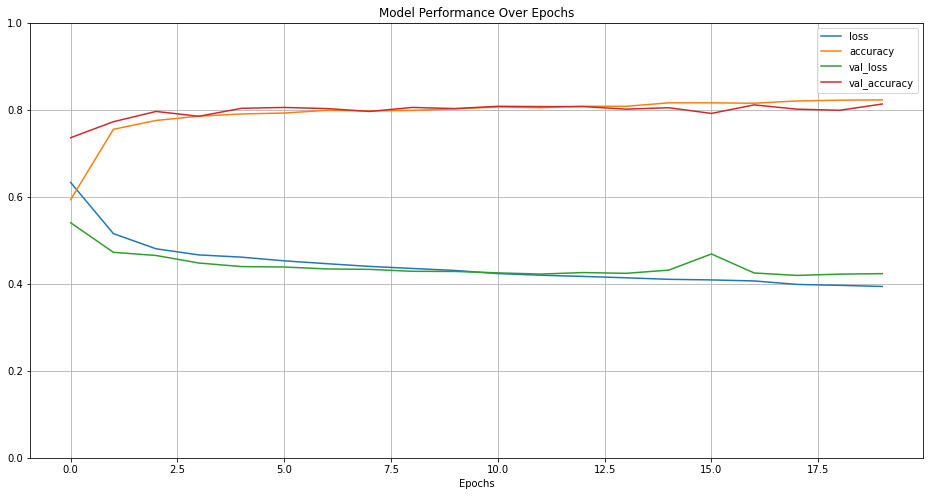

In [44]:
pd.DataFrame(history.history).plot(figsize = (16,8))
plt.xlabel("Epochs")
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Model Performance Over Epochs")
plt.show()

In [45]:
#Format test data:
test_sequences = tokenizer.texts_to_sequences(list(test.text))
test_text = pad_sequences(test_sequences, maxlen = maxlen, padding = 'post')

In [46]:
#Make Predictions
pred = model.predict_classes(test_text)

In [47]:
#Make submission file:
submission = pd.DataFrame()
submission['Id'] = test.id
submission['target'] = pred

In [48]:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets
glove.6B/            glove_extract/  twitter/            twitter_ALL.csv
glove6B_100,000.csv  test.csv        twitter_10,000.csv  twitter_extract/
glove6B_10000.csv    train.csv       twitter_100K.csv


0    2235
1    1028
Name: target, dtype: int64


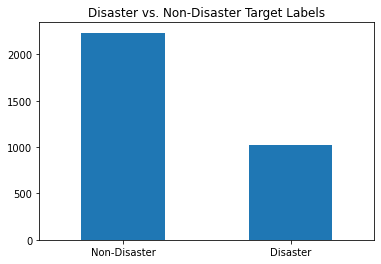

In [49]:
#Take a look at distribution of Disaster vs. Non-Disaster Predictions:
print(submission['target'].value_counts())
submission['target'].value_counts().plot(kind = 'bar')
plt.xticks(ticks = [0,1],labels = ['Non-Disaster','Disaster'], rotation = 'horizontal')
plt.title('Disaster vs. Non-Disaster Target Labels')
plt.show()

In [50]:
# submission.to_csv('FileName.csv', index = False)

So all the above code is the outline for how I am going to conduct my factorial experiment. 

## Factorial Experiment:

For this assignment, I am going to evaluate four language models. The two factors I will evaluate are:
- Pretrained Word Vectors
  - glove.6B.50d
  - glove.twitter.27B.50d
- Vocabulary Size
  - 10,000
  - 100,000

This study will follow a completely crossed 2-by-2 experimental design resulting in four distinct language models. 

For each cell in the design I will compute the processing time to train the model (in seconds), the training data accuracy, the validation accuracy, and the F1 score between predicted values and expected answers as provided by Kaggle. 

### glove.6B.50d & Vocab = 10,000

In [51]:
#Read in the data:
train = pd.read_csv("/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/train.csv")
test = pd.read_csv("/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/test.csv")

In [52]:
#Set max_words / Set the vocabulary size
max_words = 10000 #Set embedding matrix vocabulary size

In [53]:
#Set up the Tokenizer/Encoder for the words:
tokenizer = Tokenizer(num_words = max_words, oov_token="<OOV>") #Set max number of words to keep/tokenize words in training data
tokenizer.fit_on_texts(list(train.text)) #Updates internal vocabulary for dataset
sequences = tokenizer.texts_to_sequences(list(train.text)) #transforms each text in texts to a sequence of integers
word_index = tokenizer.word_index #Sets up word --> index value

#Note, be sure that the input data is a list of strings.

In [54]:
#Determine min and max tweet length:
max_tweet_length = 0
min_tweet_length = 0
for tweet in sequences:
  max_tweet_length = max(max_tweet_length, len(tweet))
  min_tweet_length = min(min_tweet_length, len(tweet))
print('Max Tweet Length:', max_tweet_length)
print('Min Tweet Length:', min_tweet_length)

#set maxlen
maxlen = max_tweet_length

Max Tweet Length: 33
Min Tweet Length: 0


In [55]:
#Pad the sequences
train_text = pad_sequences(sequences, maxlen = maxlen, padding = 'post')
labels = np.asarray(train.target)

In [56]:
#Verify shape of data:
print("train_text shape:", train_text.shape)
print("labels shape:", labels.shape)

train_text shape: (7613, 33)
labels shape: (7613,)


In [57]:
#Split training data into training set and validation set:
seed = 42
X_train, X_val, y_train, y_val = train_test_split(train_text, labels, test_size = 0.2,
                                                  random_state = seed,
                                                  stratify = labels)

In [58]:
#Set path to where glove embedding files are located:
glove_dir = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract'
twitter_dir = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter_extract'
embedding_name = 'glove.6B.50d.txt' #<--- This is the pre-trained embedding I will use.

In [59]:
#Verify working directory:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/
!pwd

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets
/content/drive/My Drive/MSDS 422 - ML/DisasterTweets


In [60]:
#Set embedding index
embedding_index = {}

In [61]:
#Read in the embedding
f = open(os.path.join(glove_dir, embedding_name), encoding = 'utf8')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embedding_index[word] = coefs
f.close()

In [62]:
#Confirm words loaded in for use in the embedding index:
print("Vector Embeddings for {}:".format(embedding_name),len(embedding_index))

Vector Embeddings for glove.6B.50d.txt: 400000


In [63]:
#Set up embedding matrix:
embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [64]:
#Verify Vocabulary size and dimensions of embedding matrix
print("Dimensions of Embedding Matrix:",embedding_matrix.shape)

Dimensions of Embedding Matrix: (10000, 50)


In [65]:
#Set up pre-trained embeddings layer:
embedding_layer = Embedding(
    input_dim = max_words,
    output_dim = embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    trainable = False
)

In [66]:
#Now Build the model:
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          500000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         58880     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 604,321
Trainable params: 104,321
Non-trainable params: 500,000
__________________________________________

Will keep the model and number of epochs for testing constant for this study. Model will be the same as the one shown above. I will use 10 epochs for each model.

In [67]:
#Compile the model:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [68]:
#Train the model:
start = datetime.now()
history = model.fit(X_train, y_train, epochs = 10, 
                    validation_data = (X_val, y_val))
end = datetime.now()
processing_time = end - start
processing_time_round = round(processing_time.total_seconds(),2)
training_accuracy = history.history['accuracy'][-1]
training_accuracy_round = round(training_accuracy, 4)
validation_accuracy = history.history['val_accuracy'][-1]
validation_accuracy_round = round(validation_accuracy,4)

results = np.array([[embedding_name,max_words,processing_time_round,
                     training_accuracy_round, validation_accuracy_round]])

Epoch 1/10
191/191 [==============================] - 8s 19ms/step - loss: 0.6642 - accuracy: 0.5875 - val_loss: 0.5167 - val_accuracy: 0.7603
Epoch 2/10
191/191 [==============================] - 2s 12ms/step - loss: 0.5144 - accuracy: 0.7547 - val_loss: 0.4726 - val_accuracy: 0.7682
Epoch 3/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4752 - accuracy: 0.7815 - val_loss: 0.4514 - val_accuracy: 0.7859
Epoch 4/10
191/191 [==============================] - 2s 13ms/step - loss: 0.4655 - accuracy: 0.7888 - val_loss: 0.4587 - val_accuracy: 0.7971
Epoch 5/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4676 - accuracy: 0.7852 - val_loss: 0.4382 - val_accuracy: 0.7991
Epoch 6/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4407 - accuracy: 0.7924 - val_loss: 0.4422 - val_accuracy: 0.7991
Epoch 7/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4495 - accuracy: 0.7880 - val_loss: 0.4397 - val_accuracy: 0.7800

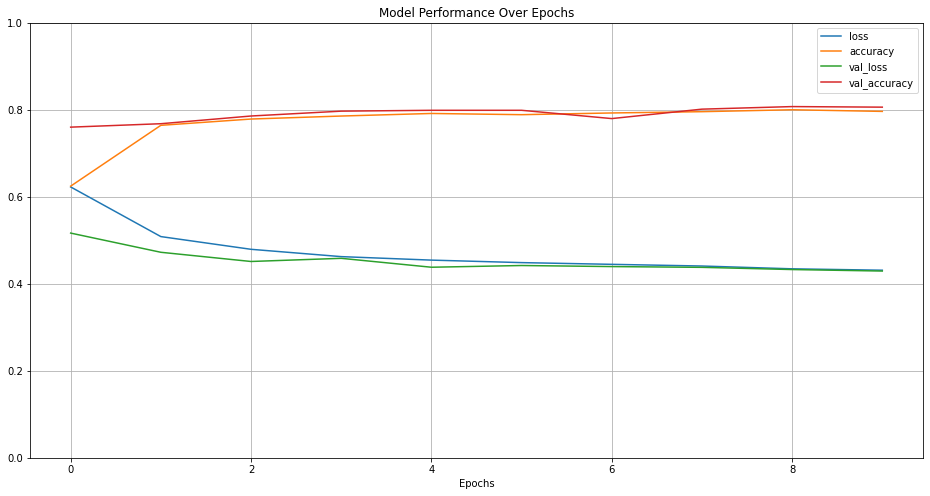

In [69]:
#Look at this models performance:
pd.DataFrame(history.history).plot(figsize = (16,8))
plt.xlabel("Epochs")
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Model Performance Over Epochs")
plt.show()

In [70]:
#Format test data:
test_sequences = tokenizer.texts_to_sequences(list(test.text))
test_text = pad_sequences(test_sequences, maxlen = maxlen, padding = 'post')

In [71]:
#Make Predictions
pred = model.predict_classes(test_text)

In [72]:
#Make submission file:
submission = pd.DataFrame()
submission['Id'] = test.id
submission['target'] = pred

In [73]:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets
glove.6B/            glove_extract/  twitter/            twitter_ALL.csv
glove6B_100,000.csv  test.csv        twitter_10,000.csv  twitter_extract/
glove6B_10000.csv    train.csv       twitter_100K.csv


0    2346
1     917
Name: target, dtype: int64


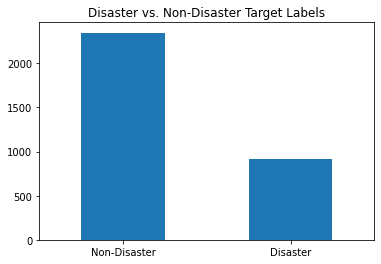

In [74]:
#Take a look at distribution of Disaster vs. Non-Disaster Predictions:
print(submission['target'].value_counts())
submission['target'].value_counts().plot(kind = 'bar')
plt.xticks(ticks = [0,1],labels = ['Non-Disaster','Disaster'], rotation = 'horizontal')
plt.title('Disaster vs. Non-Disaster Target Labels')
plt.show()

In [75]:
submission.to_csv('glove6B_10000.csv', index = False)

#### Kaggle.com Score: 0.78118 UserID: MikeSoukup Submitted on 3/6/2021 @ 4:21 PM CST

In [76]:
F1_score = [0.78118]

### glove.6B.50d & Vocab = 100,000

In [77]:
#Read in the data:
train = pd.read_csv("/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/train.csv")
test = pd.read_csv("/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/test.csv")

In [78]:
#Set max_words / Set the vocabulary size
max_words = 100000 #Set embedding matrix vocabulary size

In [79]:
#Set up the Tokenizer/Encoder for the words:
tokenizer = Tokenizer(num_words = max_words, oov_token="<OOV>") #Set max number of words to keep/tokenize words in training data
tokenizer.fit_on_texts(list(train.text)) #Updates internal vocabulary for dataset
sequences = tokenizer.texts_to_sequences(list(train.text)) #transforms each text in texts to a sequence of integers
word_index = tokenizer.word_index #Sets up word --> index value

#Note, be sure that the input data is a list of strings.

In [80]:
#Determine min and max tweet length:
max_tweet_length = 0
min_tweet_length = 0
for tweet in sequences:
  max_tweet_length = max(max_tweet_length, len(tweet))
  min_tweet_length = min(min_tweet_length, len(tweet))
print('Max Tweet Length:', max_tweet_length)
print('Min Tweet Length:', min_tweet_length)

#set maxlen
maxlen = max_tweet_length

Max Tweet Length: 33
Min Tweet Length: 0


In [81]:
#Pad the sequences
train_text = pad_sequences(sequences, maxlen = maxlen, padding = 'post')
labels = np.asarray(train.target)

In [82]:
#Verify shape of data:
print("train_text shape:", train_text.shape)
print("labels shape:", labels.shape)

train_text shape: (7613, 33)
labels shape: (7613,)


In [83]:
#Split training data into training set and validation set:
seed = 42
X_train, X_val, y_train, y_val = train_test_split(train_text, labels, test_size = 0.2,
                                                  random_state = seed,
                                                  stratify = labels)

In [84]:
#Set path to where glove embedding files are located:
glove_dir = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract'
twitter_dir = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter_extract'
embedding_name = 'glove.6B.50d.txt' #<--- This is the pre-trained embedding I will use.

In [85]:
#Verify working directory:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/
!pwd

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets
/content/drive/My Drive/MSDS 422 - ML/DisasterTweets


In [86]:
#Set embedding index
embedding_index = {}

In [87]:
#Read in the embedding
f = open(os.path.join(glove_dir, embedding_name), encoding = 'utf8')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embedding_index[word] = coefs
f.close()

In [88]:
#Confirm words loaded in for use in the embedding index:
print("Vector Embeddings for {}:".format(embedding_name),len(embedding_index))

Vector Embeddings for glove.6B.50d.txt: 400000


In [89]:
#Set up embedding matrix:
embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [90]:
#Verify Vocabulary size and dimensions of embedding matrix
print("Dimensions of Embedding Matrix:",embedding_matrix.shape)

Dimensions of Embedding Matrix: (100000, 50)


In [91]:
#Set up pre-trained embeddings layer:
embedding_layer = Embedding(
    input_dim = max_words,
    output_dim = embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    trainable = False
)

In [92]:
#Now Build the model:
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          5000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         58880     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,104,321
Trainable params: 104,321
Non-trainable params: 5,000,000
______________________________________

In [93]:
#Compile the model:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [94]:
#Train the model:
start = datetime.now()
history = model.fit(X_train, y_train, epochs = 10, 
                    validation_data = (X_val, y_val))
end = datetime.now()
processing_time = end - start
processing_time_round = round(processing_time.total_seconds(),2)
training_accuracy = history.history['accuracy'][-1]
training_accuracy_round = round(training_accuracy, 4)
validation_accuracy = history.history['val_accuracy'][-1]
validation_accuracy_round = round(validation_accuracy,4)

results = np.vstack((results, [[embedding_name,max_words,processing_time_round,
                     training_accuracy_round, validation_accuracy_round]]))

Epoch 1/10
191/191 [==============================] - 9s 19ms/step - loss: 0.6551 - accuracy: 0.5811 - val_loss: 0.5092 - val_accuracy: 0.7689
Epoch 2/10
191/191 [==============================] - 2s 13ms/step - loss: 0.5050 - accuracy: 0.7658 - val_loss: 0.4737 - val_accuracy: 0.7866
Epoch 3/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4689 - accuracy: 0.7937 - val_loss: 0.4554 - val_accuracy: 0.7886
Epoch 4/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4653 - accuracy: 0.7866 - val_loss: 0.4468 - val_accuracy: 0.7997
Epoch 5/10
191/191 [==============================] - 3s 15ms/step - loss: 0.4435 - accuracy: 0.8045 - val_loss: 0.4419 - val_accuracy: 0.7912
Epoch 6/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4421 - accuracy: 0.8052 - val_loss: 0.4361 - val_accuracy: 0.8030
Epoch 7/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4396 - accuracy: 0.7968 - val_loss: 0.4325 - val_accuracy: 0.8043

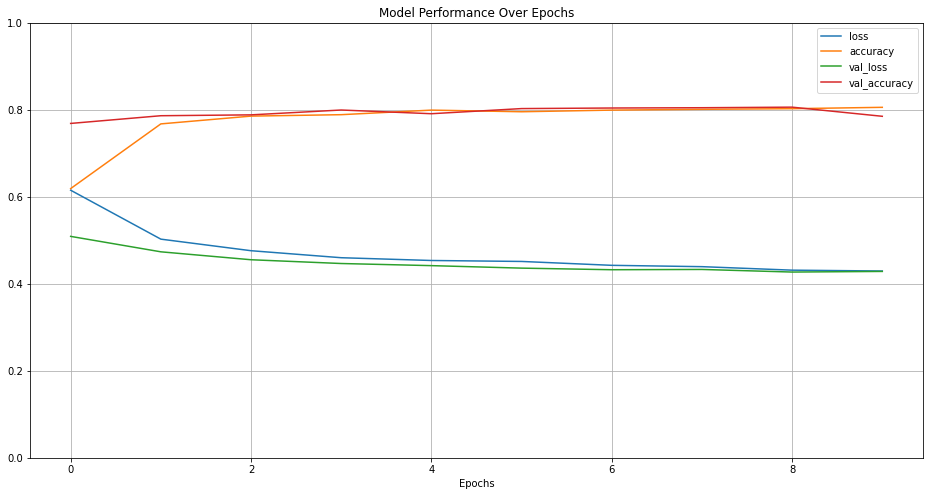

In [95]:
#Look at this models performance:
pd.DataFrame(history.history).plot(figsize = (16,8))
plt.xlabel("Epochs")
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Model Performance Over Epochs")
plt.show()

In [96]:
#Format test data:
test_sequences = tokenizer.texts_to_sequences(list(test.text))
test_text = pad_sequences(test_sequences, maxlen = maxlen, padding = 'post')

In [97]:
#Make Predictions
pred = model.predict_classes(test_text)

In [98]:
#Make submission file:
submission = pd.DataFrame()
submission['Id'] = test.id
submission['target'] = pred

In [99]:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets
glove.6B/            glove_extract/  twitter/            twitter_ALL.csv
glove6B_100,000.csv  test.csv        twitter_10,000.csv  twitter_extract/
glove6B_10000.csv    train.csv       twitter_100K.csv


0    2466
1     797
Name: target, dtype: int64


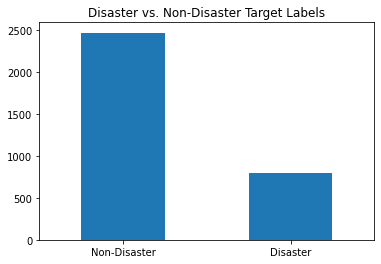

In [100]:
#Take a look at distribution of Disaster vs. Non-Disaster Predictions:
print(submission['target'].value_counts())
submission['target'].value_counts().plot(kind = 'bar')
plt.xticks(ticks = [0,1],labels = ['Non-Disaster','Disaster'], rotation = 'horizontal')
plt.title('Disaster vs. Non-Disaster Target Labels')
plt.show()

In [101]:
submission.to_csv('glove6B_100,000.csv', index = False)

#### Kaggle.com Score: 0.79436 UserID: MikeSoukup Submitted on 3/6/2021 @ 4:35 PM CST

In [102]:
F1_score.append(0.79436)

### glove.twitter.27B.50d & Vocab = 10,000

In [103]:
#Read in the data:
train = pd.read_csv("/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/train.csv")
test = pd.read_csv("/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/test.csv")

In [104]:
#Set max_words / Set the vocabulary size
max_words = 10000 #Set embedding matrix vocabulary size

In [105]:
#Set up the Tokenizer/Encoder for the words:
tokenizer = Tokenizer(num_words = max_words, oov_token="<OOV>") #Set max number of words to keep/tokenize words in training data
tokenizer.fit_on_texts(list(train.text)) #Updates internal vocabulary for dataset
sequences = tokenizer.texts_to_sequences(list(train.text)) #transforms each text in texts to a sequence of integers
word_index = tokenizer.word_index #Sets up word --> index value

#Note, be sure that the input data is a list of strings.

In [106]:
#Determine min and max tweet length:
max_tweet_length = 0
min_tweet_length = 0
for tweet in sequences:
  max_tweet_length = max(max_tweet_length, len(tweet))
  min_tweet_length = min(min_tweet_length, len(tweet))
print('Max Tweet Length:', max_tweet_length)
print('Min Tweet Length:', min_tweet_length)

#set maxlen
maxlen = max_tweet_length

Max Tweet Length: 33
Min Tweet Length: 0


In [107]:
#Pad the sequences
train_text = pad_sequences(sequences, maxlen = maxlen, padding = 'post')
labels = np.asarray(train.target)

In [108]:
#Verify shape of data:
print("train_text shape:", train_text.shape)
print("labels shape:", labels.shape)

train_text shape: (7613, 33)
labels shape: (7613,)


In [109]:
#Split training data into training set and validation set:
seed = 42
X_train, X_val, y_train, y_val = train_test_split(train_text, labels, test_size = 0.2,
                                                  random_state = seed,
                                                  stratify = labels)

In [110]:
#Set path to where glove embedding files are located:
glove_dir = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract'
twitter_dir = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter_extract'
embedding_name = 'glove.twitter.27B.50d.txt' #<--- This is the pre-trained embedding I will use.

In [111]:
#Verify working directory:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/
!pwd

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets
/content/drive/My Drive/MSDS 422 - ML/DisasterTweets


In [112]:
#Set embedding index
embedding_index = {}

In [113]:
#Read in the embedding
f = open(os.path.join(twitter_dir, embedding_name), encoding = 'utf8')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embedding_index[word] = coefs
f.close()

In [114]:
#Confirm words loaded in for use in the embedding index:
print("Vector Embeddings for {}:".format(embedding_name),len(embedding_index))

Vector Embeddings for glove.twitter.27B.50d.txt: 1193514


In [115]:
#Set up embedding matrix:
embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [116]:
#Verify Vocabulary size and dimensions of embedding matrix
print("Dimensions of Embedding Matrix:",embedding_matrix.shape)

Dimensions of Embedding Matrix: (10000, 50)


In [117]:
#Set up pre-trained embeddings layer:
embedding_layer = Embedding(
    input_dim = max_words,
    output_dim = embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    trainable = False
)

In [118]:
#Now Build the model:
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 50)          500000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 128)         58880     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 604,321
Trainable params: 104,321
Non-trainable params: 500,000
__________________________________________

In [119]:
#Compile the model:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [120]:
#Train the model:
start = datetime.now()
history = model.fit(X_train, y_train, epochs = 10, 
                    validation_data = (X_val, y_val))
end = datetime.now()
processing_time = end - start
processing_time_round = round(processing_time.total_seconds(),2)
training_accuracy = history.history['accuracy'][-1]
training_accuracy_round = round(training_accuracy, 4)
validation_accuracy = history.history['val_accuracy'][-1]
validation_accuracy_round = round(validation_accuracy,4)

results = np.vstack((results, [[embedding_name,max_words,processing_time_round,
                     training_accuracy_round, validation_accuracy_round]]))

Epoch 1/10
191/191 [==============================] - 9s 20ms/step - loss: 0.6649 - accuracy: 0.5840 - val_loss: 0.5356 - val_accuracy: 0.7413
Epoch 2/10
191/191 [==============================] - 2s 13ms/step - loss: 0.5296 - accuracy: 0.7504 - val_loss: 0.4609 - val_accuracy: 0.7695
Epoch 3/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4844 - accuracy: 0.7772 - val_loss: 0.4374 - val_accuracy: 0.7971
Epoch 4/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4638 - accuracy: 0.7900 - val_loss: 0.4303 - val_accuracy: 0.8043
Epoch 5/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4326 - accuracy: 0.8069 - val_loss: 0.4271 - val_accuracy: 0.7965
Epoch 6/10
191/191 [==============================] - 3s 14ms/step - loss: 0.4445 - accuracy: 0.8009 - val_loss: 0.4231 - val_accuracy: 0.8063
Epoch 7/10
191/191 [==============================] - 3s 13ms/step - loss: 0.4438 - accuracy: 0.7928 - val_loss: 0.4201 - val_accuracy: 0.8063

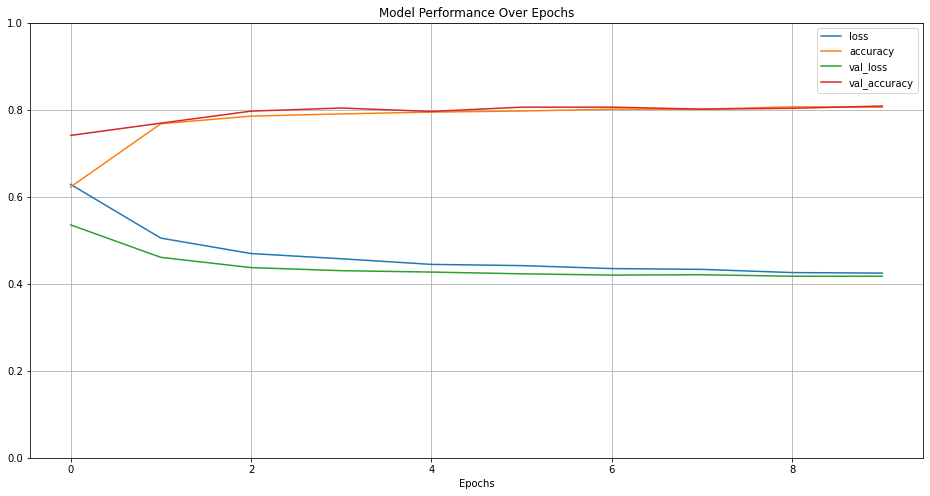

In [121]:
#Look at this models performance:
pd.DataFrame(history.history).plot(figsize = (16,8))
plt.xlabel("Epochs")
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Model Performance Over Epochs")
plt.show()

In [122]:
#Format test data:
test_sequences = tokenizer.texts_to_sequences(list(test.text))
test_text = pad_sequences(test_sequences, maxlen = maxlen, padding = 'post')

In [123]:
#Make Predictions
pred = model.predict_classes(test_text)

In [124]:
#Make submission file:
submission = pd.DataFrame()
submission['Id'] = test.id
submission['target'] = pred

In [125]:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets
glove.6B/            glove_extract/  twitter/            twitter_ALL.csv
glove6B_100,000.csv  test.csv        twitter_10,000.csv  twitter_extract/
glove6B_10000.csv    train.csv       twitter_100K.csv


0    2353
1     910
Name: target, dtype: int64


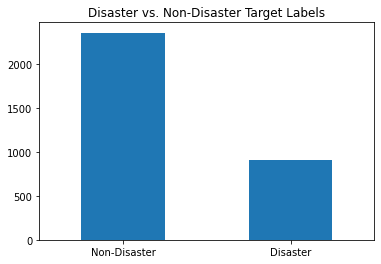

In [126]:
#Take a look at distribution of Disaster vs. Non-Disaster Predictions:
print(submission['target'].value_counts())
submission['target'].value_counts().plot(kind = 'bar')
plt.xticks(ticks = [0,1],labels = ['Non-Disaster','Disaster'], rotation = 'horizontal')
plt.title('Disaster vs. Non-Disaster Target Labels')
plt.show()

In [127]:
submission.to_csv('twitter_10,000.csv', index = False)

#### Kaggle.com Score: 0.79007 UserId: MikeSoukup Submitted on 3/6/2021 @ 4:47 PM CST

In [128]:
F1_score.append(0.79007)

### glove.twitter.27B.50d & Vocab = 100,000

In [129]:
#Read in the data:
train = pd.read_csv("/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/train.csv")
test = pd.read_csv("/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/test.csv")

In [130]:
#Set max_words / Set the vocabulary size
max_words = 100000 #Set embedding matrix vocabulary size

In [131]:
#Set up the Tokenizer/Encoder for the words:
tokenizer = Tokenizer(num_words = max_words, oov_token="<OOV>") #Set max number of words to keep/tokenize words in training data
tokenizer.fit_on_texts(list(train.text)) #Updates internal vocabulary for dataset
sequences = tokenizer.texts_to_sequences(list(train.text)) #transforms each text in texts to a sequence of integers
word_index = tokenizer.word_index #Sets up word --> index value

#Note, be sure that the input data is a list of strings.

In [132]:
#Determine min and max tweet length:
max_tweet_length = 0
min_tweet_length = 0
for tweet in sequences:
  max_tweet_length = max(max_tweet_length, len(tweet))
  min_tweet_length = min(min_tweet_length, len(tweet))
print('Max Tweet Length:', max_tweet_length)
print('Min Tweet Length:', min_tweet_length)

#set maxlen
maxlen = max_tweet_length

Max Tweet Length: 33
Min Tweet Length: 0


In [133]:
#Pad the sequences
train_text = pad_sequences(sequences, maxlen = maxlen, padding = 'post')
labels = np.asarray(train.target)

In [134]:
#Verify shape of data:
print("train_text shape:", train_text.shape)
print("labels shape:", labels.shape)

train_text shape: (7613, 33)
labels shape: (7613,)


In [135]:
#Split training data into training set and validation set:
seed = 42
X_train, X_val, y_train, y_val = train_test_split(train_text, labels, test_size = 0.2,
                                                  random_state = seed,
                                                  stratify = labels)

In [136]:
#Set path to where glove embedding files are located:
glove_dir = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract'
twitter_dir = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter_extract'
embedding_name = 'glove.twitter.27B.50d.txt' #<--- This is the pre-trained embedding I will use.

In [137]:
#Verify working directory:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/
!pwd

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets
/content/drive/My Drive/MSDS 422 - ML/DisasterTweets


In [138]:
#Set embedding index
embedding_index = {}

In [139]:
#Read in the embedding
f = open(os.path.join(twitter_dir, embedding_name), encoding = 'utf8')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embedding_index[word] = coefs
f.close()

In [140]:
#Confirm words loaded in for use in the embedding index:
print("Vector Embeddings for {}:".format(embedding_name),len(embedding_index))

Vector Embeddings for glove.twitter.27B.50d.txt: 1193514


In [141]:
#Set up embedding matrix:
embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [142]:
#Verify Vocabulary size and dimensions of embedding matrix
print("Dimensions of Embedding Matrix:",embedding_matrix.shape)

Dimensions of Embedding Matrix: (100000, 50)


In [143]:
#Set up pre-trained embeddings layer:
embedding_layer = Embedding(
    input_dim = max_words,
    output_dim = embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    trainable = False
)

In [144]:
#Now Build the model:
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 50)          5000000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 128)         58880     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 5,104,321
Trainable params: 104,321
Non-trainable params: 5,000,000
______________________________________

In [145]:
#Compile the model:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [146]:
#Train the model:
start = datetime.now()
history = model.fit(X_train, y_train, epochs = 10, 
                    validation_data = (X_val, y_val))
end = datetime.now()
processing_time = end - start
processing_time_round = round(processing_time.total_seconds(),2)
training_accuracy = history.history['accuracy'][-1]
training_accuracy_round = round(training_accuracy, 4)
validation_accuracy = history.history['val_accuracy'][-1]
validation_accuracy_round = round(validation_accuracy,4)

results = np.vstack((results, [[embedding_name,max_words,processing_time_round,
                     training_accuracy_round, validation_accuracy_round]]))

Epoch 1/10
191/191 [==============================] - 9s 21ms/step - loss: 0.6652 - accuracy: 0.5822 - val_loss: 0.5244 - val_accuracy: 0.7735
Epoch 2/10
191/191 [==============================] - 2s 13ms/step - loss: 0.5241 - accuracy: 0.7552 - val_loss: 0.4541 - val_accuracy: 0.7919
Epoch 3/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4785 - accuracy: 0.7849 - val_loss: 0.4403 - val_accuracy: 0.7971
Epoch 4/10
191/191 [==============================] - 2s 13ms/step - loss: 0.4583 - accuracy: 0.7920 - val_loss: 0.4375 - val_accuracy: 0.7951
Epoch 5/10
191/191 [==============================] - 2s 13ms/step - loss: 0.4533 - accuracy: 0.7923 - val_loss: 0.4280 - val_accuracy: 0.7978
Epoch 6/10
191/191 [==============================] - 3s 14ms/step - loss: 0.4429 - accuracy: 0.7969 - val_loss: 0.4229 - val_accuracy: 0.8037
Epoch 7/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4279 - accuracy: 0.8128 - val_loss: 0.4240 - val_accuracy: 0.7978

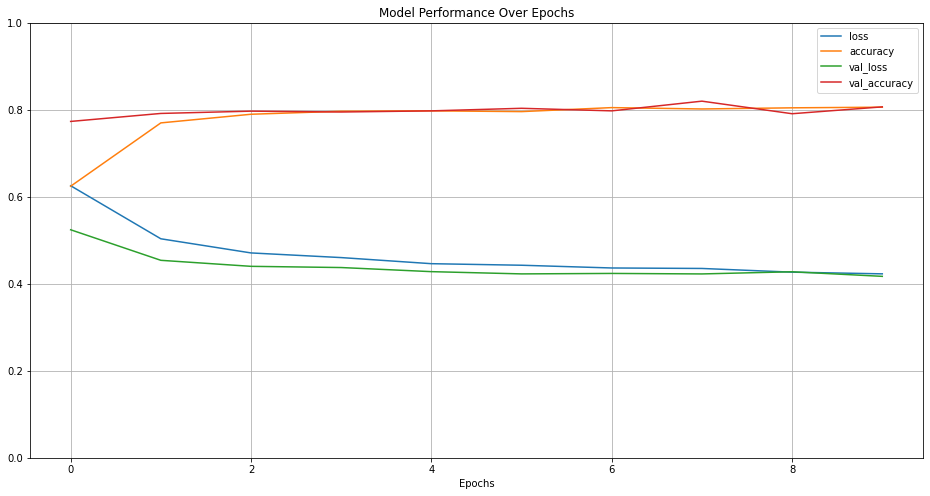

In [147]:
#Look at this models performance:
pd.DataFrame(history.history).plot(figsize = (16,8))
plt.xlabel("Epochs")
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Model Performance Over Epochs")
plt.show()

In [148]:
#Format test data:
test_sequences = tokenizer.texts_to_sequences(list(test.text))
test_text = pad_sequences(test_sequences, maxlen = maxlen, padding = 'post')

In [149]:
#Make Predictions
pred = model.predict_classes(test_text)

In [150]:
#Make submission file:
submission = pd.DataFrame()
submission['Id'] = test.id
submission['target'] = pred

In [151]:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets
glove.6B/            glove_extract/  twitter/            twitter_ALL.csv
glove6B_100,000.csv  test.csv        twitter_10,000.csv  twitter_extract/
glove6B_10000.csv    train.csv       twitter_100K.csv


0    2353
1     910
Name: target, dtype: int64


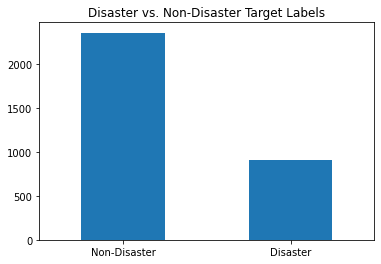

In [152]:
#Take a look at distribution of Disaster vs. Non-Disaster Predictions:
print(submission['target'].value_counts())
submission['target'].value_counts().plot(kind = 'bar')
plt.xticks(ticks = [0,1],labels = ['Non-Disaster','Disaster'], rotation = 'horizontal')
plt.title('Disaster vs. Non-Disaster Target Labels')
plt.show()

In [153]:
submission.to_csv('twitter_100K.csv', index = False)

#### Kaggle.com Score: 0.79834 UserId: MikeSoukup submitted on 3/6/2021 @ 4:58 PM CST

In [154]:
F1_score.append(0.79834)

### Review Results

In [155]:
res = pd.DataFrame(data = results, columns = ["Word_Vector","Vocabulary Size","Processing Time",
                                              "Training Accuracy","Validation Accuracy"])
res['F1_Score'] = F1_score
res

Word_Vector Vocabulary Size  ... Validation Accuracy F1_Score
0           glove.6B.50d.txt           10000  ...              0.8063  0.78118
1           glove.6B.50d.txt          100000  ...              0.7853  0.79436
2  glove.twitter.27B.50d.txt           10000  ...              0.8089  0.79007
3  glove.twitter.27B.50d.txt          100000  ...               0.807  0.79834

[4 rows x 6 columns]

In [156]:
num_col = ["Vocabulary Size","Processing Time","Training Accuracy","Validation Accuracy","F1_Score"]
for c in num_col:
  res[c] = res[c].astype('float64')
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Word_Vector          4 non-null      object 
 1   Vocabulary Size      4 non-null      float64
 2   Processing Time      4 non-null      float64
 3   Training Accuracy    4 non-null      float64
 4   Validation Accuracy  4 non-null      float64
 5   F1_Score             4 non-null      float64
dtypes: float64(5), object(1)
memory usage: 320.0+ bytes


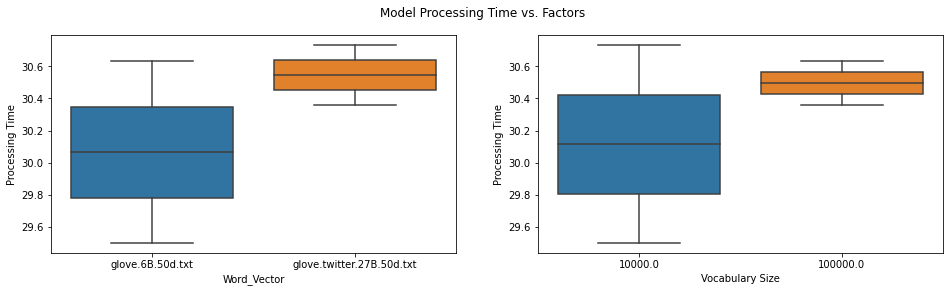

In [157]:
import seaborn as sns
fig, axs = plt.subplots(1,2, figsize = (16,4))
sns.boxplot(x = "Word_Vector", y = "Processing Time", data = res, orient = 'v', ax = axs[0])
sns.boxplot(x = "Vocabulary Size", y = "Processing Time", data = res, orient = 'v', ax = axs[1])
fig.suptitle('Model Processing Time vs. Factors')
plt.show()

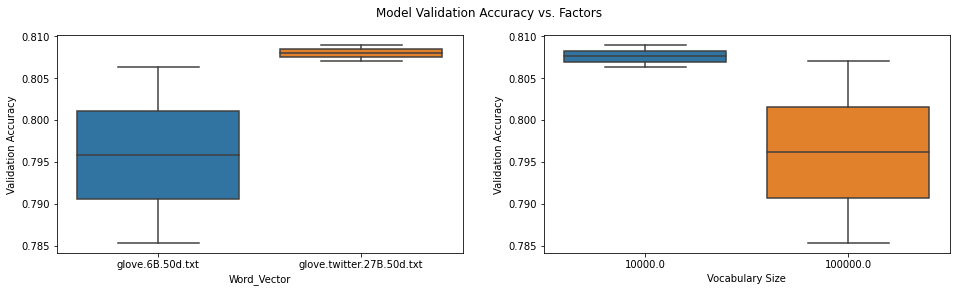

In [158]:
import seaborn as sns
fig, axs = plt.subplots(1,2, figsize = (16,4))
sns.boxplot(x = "Word_Vector", y = "Validation Accuracy", data = res, orient = 'v', ax = axs[0])
sns.boxplot(x = "Vocabulary Size", y = "Validation Accuracy", data = res, orient = 'v', ax = axs[1])
fig.suptitle('Model Validation Accuracy vs. Factors')
plt.show()

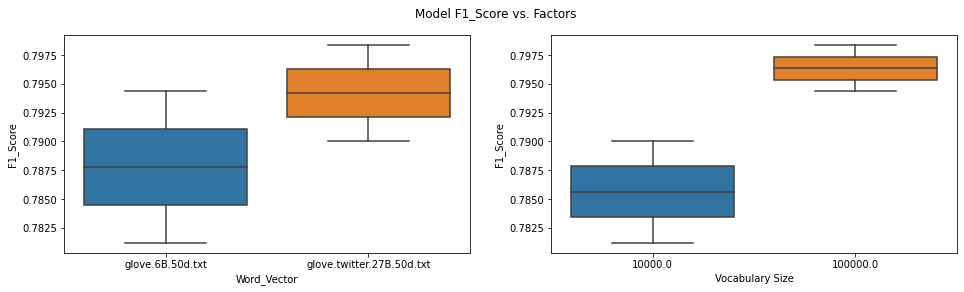

In [159]:
import seaborn as sns
fig, axs = plt.subplots(1,2, figsize = (16,4))
sns.boxplot(x = "Word_Vector", y = "F1_Score", data = res, orient = 'v', ax = axs[0])
sns.boxplot(x = "Vocabulary Size", y = "F1_Score", data = res, orient = 'v', ax = axs[1])
fig.suptitle('Model F1_Score vs. Factors')
plt.show()

### High Score Attempt glove.twitter.27B.50d & Vocab 1MM

In [160]:
#Read in the data:
train = pd.read_csv("/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/train.csv")
test = pd.read_csv("/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/test.csv")

In [161]:
#Set max_words / Set the vocabulary size
max_words = 1193514 #Set embedding matrix vocabulary size

In [162]:
#Set up the Tokenizer/Encoder for the words:
tokenizer = Tokenizer(num_words = max_words, oov_token="<OOV>") #Set max number of words to keep/tokenize words in training data
tokenizer.fit_on_texts(list(train.text)) #Updates internal vocabulary for dataset
sequences = tokenizer.texts_to_sequences(list(train.text)) #transforms each text in texts to a sequence of integers
word_index = tokenizer.word_index #Sets up word --> index value

#Note, be sure that the input data is a list of strings.

In [163]:
#Determine min and max tweet length:
max_tweet_length = 0
min_tweet_length = 0
for tweet in sequences:
  max_tweet_length = max(max_tweet_length, len(tweet))
  min_tweet_length = min(min_tweet_length, len(tweet))
print('Max Tweet Length:', max_tweet_length)
print('Min Tweet Length:', min_tweet_length)

#set maxlen
maxlen = max_tweet_length

Max Tweet Length: 33
Min Tweet Length: 0


In [164]:
#Pad the sequences
train_text = pad_sequences(sequences, maxlen = maxlen, padding = 'post')
labels = np.asarray(train.target)

In [165]:
#Verify shape of data:
print("train_text shape:", train_text.shape)
print("labels shape:", labels.shape)

train_text shape: (7613, 33)
labels shape: (7613,)


In [166]:
#Split training data into training set and validation set:
seed = 42
X_train, X_val, y_train, y_val = train_test_split(train_text, labels, test_size = 0.2,
                                                  random_state = seed,
                                                  stratify = labels)

In [167]:
#Set path to where glove embedding files are located:
glove_dir = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract'
twitter_dir = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter_extract'
embedding_name = 'glove.twitter.27B.50d.txt' #<--- This is the pre-trained embedding I will use.

In [168]:
#Verify working directory:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/
!pwd

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets
/content/drive/My Drive/MSDS 422 - ML/DisasterTweets


In [169]:
#Set embedding index
embedding_index = {}

In [170]:
#Read in the embedding
f = open(os.path.join(twitter_dir, embedding_name), encoding = 'utf8')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embedding_index[word] = coefs
f.close()

In [171]:
#Confirm words loaded in for use in the embedding index:
print("Vector Embeddings for {}:".format(embedding_name),len(embedding_index))

Vector Embeddings for glove.twitter.27B.50d.txt: 1193514


In [172]:
#Set up embedding matrix:
embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [173]:
#Verify Vocabulary size and dimensions of embedding matrix
print("Dimensions of Embedding Matrix:",embedding_matrix.shape)

Dimensions of Embedding Matrix: (1193514, 50)


In [174]:
#Set up pre-trained embeddings layer:
embedding_layer = Embedding(
    input_dim = max_words,
    output_dim = embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    trainable = False
)

In [175]:
#Now Build the model:
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 50)          59675700  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 128)         58880     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 59,780,021
Trainable params: 104,321
Non-trainable params: 59,675,700
____________________________________

In [176]:
#Compile the model:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [177]:
#Train the model:
start = datetime.now()
history = model.fit(X_train, y_train, epochs = 10, 
                    validation_data = (X_val, y_val))
end = datetime.now()
processing_time = end - start
processing_time_round = round(processing_time.total_seconds(),2)
training_accuracy = history.history['accuracy'][-1]
training_accuracy_round = round(training_accuracy, 4)
validation_accuracy = history.history['val_accuracy'][-1]
validation_accuracy_round = round(validation_accuracy,4)

results = np.vstack((results, [[embedding_name,max_words,processing_time_round,
                     training_accuracy_round, validation_accuracy_round]]))

Epoch 1/10
191/191 [==============================] - 9s 19ms/step - loss: 0.6523 - accuracy: 0.5745 - val_loss: 0.5264 - val_accuracy: 0.7479
Epoch 2/10
191/191 [==============================] - 2s 12ms/step - loss: 0.5167 - accuracy: 0.7599 - val_loss: 0.4612 - val_accuracy: 0.7873
Epoch 3/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4772 - accuracy: 0.7871 - val_loss: 0.4391 - val_accuracy: 0.8017
Epoch 4/10
191/191 [==============================] - 2s 13ms/step - loss: 0.4568 - accuracy: 0.7916 - val_loss: 0.4303 - val_accuracy: 0.8070
Epoch 5/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4535 - accuracy: 0.8029 - val_loss: 0.4250 - val_accuracy: 0.8043
Epoch 6/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4357 - accuracy: 0.8045 - val_loss: 0.4275 - val_accuracy: 0.8188
Epoch 7/10
191/191 [==============================] - 2s 13ms/step - loss: 0.4274 - accuracy: 0.8003 - val_loss: 0.4295 - val_accuracy: 0.8148

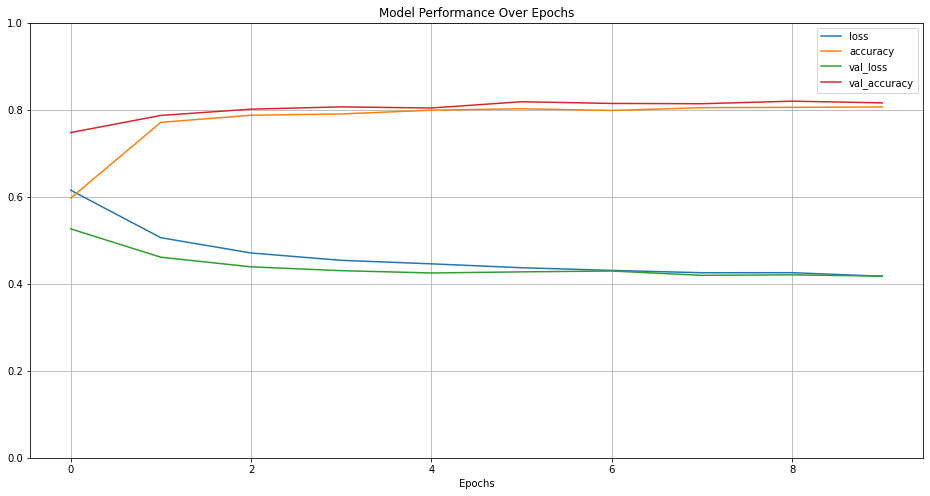

In [178]:
#Look at this models performance:
pd.DataFrame(history.history).plot(figsize = (16,8))
plt.xlabel("Epochs")
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Model Performance Over Epochs")
plt.show()

In [179]:
#Format test data:
test_sequences = tokenizer.texts_to_sequences(list(test.text))
test_text = pad_sequences(test_sequences, maxlen = maxlen, padding = 'post')

In [180]:
#Make Predictions
pred = model.predict_classes(test_text)

In [181]:
#Make submission file:
submission = pd.DataFrame()
submission['Id'] = test.id
submission['target'] = pred

In [182]:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets
glove.6B/            glove_extract/  twitter/            twitter_ALL.csv
glove6B_100,000.csv  test.csv        twitter_10,000.csv  twitter_extract/
glove6B_10000.csv    train.csv       twitter_100K.csv


0    2295
1     968
Name: target, dtype: int64


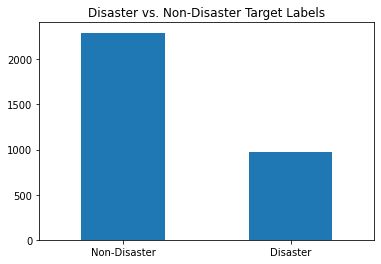

In [183]:
#Take a look at distribution of Disaster vs. Non-Disaster Predictions:
print(submission['target'].value_counts())
submission['target'].value_counts().plot(kind = 'bar')
plt.xticks(ticks = [0,1],labels = ['Non-Disaster','Disaster'], rotation = 'horizontal')
plt.title('Disaster vs. Non-Disaster Target Labels')
plt.show()

In [184]:
submission.to_csv('twitter_ALL.csv', index = False)

#### Kaggle.com Score: 0.79068 UserId: MikeSoukup submitted on 3/6/2021 @ 5:51 PM CST

In [185]:
F1_score.append(0.79068)

In [186]:
res = pd.DataFrame(data = results, columns = ["Word_Vector","Vocabulary Size","Processing Time",
                                              "Training Accuracy","Validation Accuracy"])
res['F1_Score'] = F1_score
res

Word_Vector Vocabulary Size  ... Validation Accuracy F1_Score
0           glove.6B.50d.txt           10000  ...              0.8063  0.78118
1           glove.6B.50d.txt          100000  ...              0.7853  0.79436
2  glove.twitter.27B.50d.txt           10000  ...              0.8089  0.79007
3  glove.twitter.27B.50d.txt          100000  ...               0.807  0.79834
4  glove.twitter.27B.50d.txt         1193514  ...              0.8162  0.79068

[5 rows x 6 columns]

# Appendix - Additional Code

## Bring in Embeddings

In [ ]:
#List available indices in English:
chakin.search(lang = "English")

                   Name  Dimension  ... Language    Author
2          fastText(en)        300  ...  English  Facebook
11         GloVe.6B.50d         50  ...  English  Stanford
12        GloVe.6B.100d        100  ...  English  Stanford
13        GloVe.6B.200d        200  ...  English  Stanford
14        GloVe.6B.300d        300  ...  English  Stanford
15       GloVe.42B.300d        300  ...  English  Stanford
16      GloVe.840B.300d        300  ...  English  Stanford
17    GloVe.Twitter.25d         25  ...  English  Stanford
18    GloVe.Twitter.50d         50  ...  English  Stanford
19   GloVe.Twitter.100d        100  ...  English  Stanford
20   GloVe.Twitter.200d        200  ...  English  Stanford
21  word2vec.GoogleNews        300  ...  English    Google

[12 rows x 7 columns]


In [ ]:
#Download the english embeddings from Chakin for GloVe.6B.50d
CHAKIN_INDEX = 11
NUMBER_OF_DIMENSIONS = 50
SUBFOLDER_NAME = "glove.6b"

In [ ]:
!pwd
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract
glove.6B.100d.txt  glove.6B.200d.txt  glove.6B.300d.txt  glove.6B.50d.txt


In [ ]:
#Dowload the CHAKIN Embeddings zip files
chakin_dir_zip = os.path.join(os.getcwd(),SUBFOLDER_NAME)
chakin.download(number = CHAKIN_INDEX, save_dir = chakin_dir_zip)

Test: 100% ||                                      | Time:  0:02:40   5.1 MiB/s


'/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove.6B/glove.6B.zip'

In [ ]:
twitter_dir_zip = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter'
chakin.download(number = 18,save_dir = twitter_dir_zip)

Test: 100% ||                                      | Time:  0:04:45   5.1 MiB/s


'/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter/glove.twitter.27B.zip'

In [ ]:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove.6B/
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove.6B
glove.6B.zip


In [ ]:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter/
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter
glove.twitter.27B.zip


This confirms that the zip file is in the appropriate directory. Now need to extract the embedding files from this zip file.

In [ ]:
UNZIP_DIR = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract'
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter/
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter
glove.twitter.27B.zip


In [ ]:
UNZIP_DIR = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter_extract'

In [ ]:
zip_file_name = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter/glove.twitter.27B.zip'

In [ ]:
import zipfile
with zipfile.ZipFile(zip_file_name,"r") as zip_ref:
  print("Extracting embeddings to '{}'".format(UNZIP_DIR))
  zip_ref.extractall(UNZIP_DIR)

Extracting embeddings to '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter_extract'


In [ ]:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract
glove.6B.100d.txt  glove.6B.200d.txt  glove.6B.300d.txt  glove.6B.50d.txt


In [ ]:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter_extract
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/twitter_extract
glove.twitter.27B.100d.txt  glove.twitter.27B.25d.txt
glove.twitter.27B.200d.txt  glove.twitter.27B.50d.txt


And there we go! There are the extracted embedding .txt files.

## Test Embedding

In [ ]:
#Select which embeddings to use
embeddings_directory = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract'
filename = 'glove.6B.50d.txt'
embeddings_filename = os.path.join(embeddings_directory, filename)
#Now have a path to the embedded vocabulary

In [ ]:
#Load the embedded text file:

def load_embedding(embeddings_filename, with_indexes=True):
  """
  Read an embeddings txt file. If `with_indexes = True`, we return a tuple of dictionaries
  `(word_to_index_dict, index_to_embedding_array)`, otherwise we return only a direct
  `word_to_embedding_dict` dictionary mapping from a string to a numpy array.
  """

  if with_indexes:
    word_to_index_dict = dict() #instantiate the dictionary
    index_to_embedding_array = []
  else:
    word_to_embedding_dict = dict()

  with open(embeddings_filename,'r',encoding = 'utf-8') as embeddings_file:
    for (i, line) in enumerate(embeddings_file):
      split = line.split(' ')
      word = split[0]
      representation = split[1:]
      representation = np.array(
          [float(val) for val in representation]
      )
      if with_indexes:
        word_to_index_dict[word] = i
        index_to_embedding_array.append(representation)
      else:
        word_to_embedding_dict[word] = representation

  #Empty representation for unknown words.
  _WORD_NOT_FOUND = [0.0]*len(representation)
  if with_indexes:
    _LAST_INDEX = i+1
    word_to_index_dict = defaultdict(
        lambda: _LAST_INDEX, word_to_index_dict)
    index_to_embedding_array = np.array(
        index_to_embedding_array + [_WORD_NOT_FOUND])
    return word_to_index_dict, index_to_embedding_array
  else:
    word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
    return word_to_embedding_dict

In [ ]:
#Check if the loaded embedding files glove.6B.50d. successfully loaded into the program:
print('\nLoading embeddings from', embeddings_filename)
word_to_index, index_to_embedding = \
            load_embedding(embeddings_filename, with_indexes=True)
print("Embedding loaded.")

#Note: unknown words have representations with values [0,0,...,0]


Loading embeddings from /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract/glove.6B.50d.txt
Embedding loaded.


In [ ]:
#Check the vocabulary size and embedding dimention:
vocab_size, embedding_dim = index_to_embedding.shape
print("Embedding is of shape: {}".format(index_to_embedding.shape))
print("This means (number of words, number of dimensions per word)\n")
print("The first words are words that tend to occur more often.")

Embedding is of shape: (400001, 50)
This means (number of words, number of dimensions per word)

The first words are words that tend to occur more often.


In [ ]:
#Check embedding data
print("Note: for unknown words, the representation is an empty vector, \n"
      "and the index is the last one. The dictionary has a limit:")
print("\n  {} --> {} --> {}".format("A word","Index in embedding","Representation"))
print("\nTest with fake word")
word = 'lakjsf'
idx = word_to_index[word]
complete_vocabulary_size = idx
embd = list(np.array(index_to_embedding[idx], dtype = int))
print("\n  {} --> {} --> {}".format(word, idx, embd))

Note: for unknown words, the representation is an empty vector, 
and the index is the last one. The dictionary has a limit:

  A word --> Index in embedding --> Representation

Test with fake word

  lakjsf --> 400000 --> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print("Test with real word")
word = 'test'
idx = word_to_index[word]
embd = list(np.array(index_to_embedding[idx], dtype = int))
print("\n  {} --> {} --> {}".format(word, idx, embd))

Test with real word

  test --> 728 --> [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [ ]:
#Use the embeddings dictionaries with a test sentence:
test_sentence = 'The quick brown fox jumps over the lazy dog'
print('\nTest Sentence:', test_sentence,'\n')
words_in_test_sentence = test_sentence.split()
print('Test sentence embeddings from complete vocabulary of',
      complete_vocabulary_size,'words.\n')
for word in words_in_test_sentence:
  word_ = word.lower()
  embedding = index_to_embedding[word_to_index[word_]]
  print(word_ + ": ", embedding)


Test Sentence: The quick brown fox jumps over the lazy dog 

Test sentence embeddings from complete vocabulary of 400000 words.

the:  [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
quick:  [ 0.13967   -0.53798   -0.18047   -0.25142    0.16203   -0.13868
 -0.24637    0.75111    0.27264    0.61035   -0.82548    0.038647
 -0.32361    0.30373   -0.14598   -0.23551    0.39267   -1.1287
 -0.23636   -1.0629     0.046277   0.29143   -0.258

## Define Vocabulary Size

In [ ]:
#Define vocabulary size for the language model:
EVOCABSIZE = 10000

def default_factory():
  return EVOCABSIZE

limited_word_to_index = defaultdict(default_factory, \
    {k: v for k, v in word_to_index.items() if v < EVOCABSIZE})

In [ ]:
#Select the first EVOCABSIZE rows to the index_to_embedding
limited_index_to_embedding = index_to_embedding[0:EVOCABSIZE,:]

In [ ]:
limited_index_to_embedding.shape

(10000, 50)

Here, we can see instead of 400,000 words we are only working with a limited vocabulary size of 10,000 words (or whatever other size that is specified by the EVOCABSIZE variable).

In [ ]:
#Now set the unknown-word row to be all zeros:
limited_index_to_embedding = np.append(limited_index_to_embedding,
                                       index_to_embedding[index_to_embedding.shape[0]-1,:].\
                                       reshape(1,embedding_dim), axis = 0)

In [ ]:
limited_index_to_embedding.shape

(10001, 50)

In [ ]:
limited_index_to_embedding[-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Here it is clear we have added one more row, the unknown word row, at the end of the index to embeddings array that is made up of all zeros.

## Prepare Data

First follow data preparation instructions from https://keras.io/examples/nlp/pretrained_word_embeddings/

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
train_list = list(df_train['text'])
test_list = list(df_test['text'])

In [ ]:
print("train_list data type:", type(train_list))
print("length train_list:", len(train_list))
print("test_list data type:",type(test_list))
print("length test_list:",len(test_list))

train_list data type: <class 'list'>
length train_list: 7613
test_list data type: <class 'list'>
length test_list: 3263


Now I have a list of data, where each item in the list is a tweet.

In [ ]:
train_list[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [ ]:
#Also need to create a list of labels!
train_label_list = list(df_train['target'])
print("train_label_list data type:",type(train_label_list))
print("length train_label_list:",len(train_label_list))

train_label_list data type: <class 'list'>
length train_label_list: 7613


In [ ]:
#Shuffle and split the data into training and validation sets:
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(train_list)
rng = np.random.RandomState(seed)
rng.shuffle(train_label_list)

In [ ]:
train_list[0]

'Why Charlie Lim start at 9pm on this Sunday..... I have curfew leh :-('

So here we can see we have suffled up the training data and the training labels.

In [ ]:
#Now split the training data into a training and validation set
val_split = 0.2
num_val_samples = int(val_split*len(train_list))
train_samples = train_list[:-num_val_samples]
val_samples = train_list[-num_val_samples:]
train_labels = train_label_list[:-num_val_samples]
val_labels = train_label_list[-num_val_samples:] 

In [ ]:
#Now create a vocabulary index:
#Will use the TextVectorization to index the vocabulary found in the dataset
#This layer will only consider the top 20,000 words and will truncate or pad
#sequences to be 200 tokens long
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vectorizer = TextVectorization(max_tokens = 20000, output_sequence_length = 200)
#Note, here a token means a word
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
#Ok, now let's look at some of the words in the vocabulary:
print("top 20 words:\n")
print(vectorizer.get_vocabulary()[:19])
print("bottom 20 words:\n")
print(vectorizer.get_vocabulary()[-20:])

top 20 words:

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is', 'for', 'on', 'you', 'my', 'that', 'it', 'with', 'at', 'by']
bottom 20 words:

['061', '0605', '05th', '05082015', '045', '0400', '034', '030811', '0306', '03', '0215', '0206', '0111', '0106', '010217', '010156', '005225', '0025', '001116', '0011']


From this, it is clear that the top 20 words are very common words while the bottom 20 tokens are most likely unique to single tweets. They are numbers and not so much words. 

In [ ]:
#As an example, let's vectorize a test sentence:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0,:6]

array([    2,  1196,  2498,    11,     2, 10137])

So here we can see that "the" gets represented by a 2, "cat" 1196, "sat" 2498"... so this is one way to convert words to numbers.

Reminder for this vectorization, 0 is reserved for padding and index is reserved for "out of vocabulary" words.

In [ ]:
#Great a dict to map words to their indices:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc,range(len(voc))))

In [ ]:
#test to see if we get same encoding here:
test = ["the","cat","sat","on","the","mat"]
[word_index[w] for w in test]

[2, 1196, 2498, 11, 2, 10137]

See we get the same mapping of the words to an index.

In [ ]:
%cd /content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract/
%ls

/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract
glove.6B.100d.txt  glove.6B.200d.txt  glove.6B.300d.txt  glove.6B.50d.txt


In [ ]:
#Now make a dict mapping words (strings) to their NumPy vector representation:
path_to_glove_file = '/content/drive/My Drive/MSDS 422 - ML/DisasterTweets/glove_extract/glove.6B.50d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs,"f",sep=" ")
    embeddings_index[word] = coefs
print("Found %s word vectors."%len(embeddings_index))

Found 400000 word vectors.


Ok, this looks right and like it matches the 400,000 word vectors within the glove.6B.50d.txt file.

Now, let's prepare a corresponding embedding matrix that we can use in Keras Embedding layer. This is a NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [ ]:
num_tokens = len(voc) + 2 #Number of unique vocabulary words in the training dataset.
embedding_dim = 50 #Using the 50d glove file
hits = 0
misses = 0

#Prepare embedding matrix:
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    #Words not found in the embedding index will be all-zeros.
    #This includes the representation for "padding" and "OOV"
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 10986 words (8360 misses)


Next load the pre-trained word embeddings matrix into an Embedding layer.

Note to set the trainable=False to keep the embeddings fixed so we don't update them during training.

In [ ]:
from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    trainable = False,
)

## Build the Model

In [ ]:
int_sequences_input = keras.Input(shape=(None,), dtype = "int64")
embedded_sequences = embedding_layer(int_sequences_input)

In [ ]:
from tensorflow.keras import layers

x = layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embedded_sequences)
x = layers.GRU(128)(x)
preds = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 50)          967400    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         138240    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,253,993
Trainable params: 286,593
Non-trainable params: 967,400
_________________________________________________________________


Here we can see the model summary for the custom embedding layer, a Bidirectional GRU layer, followed by another GRU layer, then a Dense layer to predict disasters or not.

## Compile the Model

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = 'rmsprop',
              metrics = ['accuracy',tf.keras.metrics.AUC()])

## Train the Model

In [ ]:
#First, convert out list of strings data to NumPy arrays of integer indices. 
#These arrays are right-padded:
X_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
X_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [ ]:
#Look at the training and validation dataset:
print("Training Shape:", X_train.shape)
print("Training Labels:", y_train.shape)
print("Validation Shape:", X_val.shape)
print("Validation Labels:", y_val.shape)

Training Shape: (6091, 200)
Training Labels: (6091,)
Validation Shape: (1522, 200)
Validation Labels: (1522,)


Here it is clear we have sufficient training and validation data. Each Tweet was truncated / padded to 200 words.

In [ ]:
#Ex Training Data:
X_train[0]

array([   95,  2835, 10458,   728,    17,  5747,    11,    19,  1457,
           8,    22,   357, 10533,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

Here it is clear that this tweet consists of 13 words and then was padded to 200 words. These are the word indexes which will get converted to vectors when they enter the embeddings in the model construction.

In [ ]:
#Now fit the model!
history = model.fit(X_train, y_train, batch_size=128, epochs = 10, validation_data=(X_val, y_val))

Epoch 1/10
48/48 [==============================] - 92s 2s/step - loss: 0.6918 - accuracy: 0.5673 - auc_1: 0.4899 - val_loss: 0.6774 - val_accuracy: 0.5900 - val_auc_1: 0.5000
Epoch 2/10
48/48 [==============================] - 84s 2s/step - loss: 0.6880 - accuracy: 0.5569 - auc_1: 0.4944 - val_loss: 0.6781 - val_accuracy: 0.5900 - val_auc_1: 0.5000
Epoch 3/10
48/48 [==============================] - 84s 2s/step - loss: 0.6838 - accuracy: 0.5709 - auc_1: 0.4964 - val_loss: 0.6782 - val_accuracy: 0.5900 - val_auc_1: 0.5000
Epoch 4/10
48/48 [==============================] - 85s 2s/step - loss: 0.6853 - accuracy: 0.5648 - auc_1: 0.4964 - val_loss: 0.6798 - val_accuracy: 0.5900 - val_auc_1: 0.5000
Epoch 5/10
48/48 [==============================] - 85s 2s/step - loss: 0.6853 - accuracy: 0.5673 - auc_1: 0.4792 - val_loss: 0.6812 - val_accuracy: 0.5900 - val_auc_1: 0.5000
Epoch 6/10
31/48 [==================>...........] - ETA: 27s - loss: 0.6853 - accuracy: 0.5652 - auc_1: 0.4908

KeyboardInterrupt: ignored

In [ ]:
#Read training and test data and store as a list of lists
#Each list represents a document and a document is a list of words.
#Then break the text into words:

#define list of codes to be dropped from document
#carriage-returns, line-feeds, and tabs
codelist = ['\r','\n','\t']

#We will not remove stopwords in this exercise because they are important
#to keeping sentences intact
REMOVE_STOPWORDS = False

if REMOVE_STOPWORDS:
  print(nltk.corpus.stopwords.words('english'))

# previous analysis of a list of top terms showed a number of words, along 
# with contractions and other word strings to drop from further analysis, add
# these to the usual English stopwords to be dropped from a document collection
  more_stop_words = ['cant','didnt','doesnt','dont','goes','isnt','hes',\
        'shes','thats','theres','theyre','wont','youll','youre','youve', 'br'\
        've', 're', 'vs'] 
  some_proper_nouns_to_remove = ['dick','ginger','hollywood','jack',\
        'jill','john','karloff','kudrow','orson','peter','tcm','tom',\
        'toni','welles','william','wolheim','nikita']

#start with the initial list and add to it for movie text work

  stoplist = nltk.corpus.stopwords.words('english') + more_stop_words +\
      some_proper_nouns_to_remove

#First define some utility functions:
def text_parse(string):
    # replace non-alphanumeric with space 
    temp_string = re.sub('[^a-zA-Z]', '  ', string)    
    # replace codes with space
    for i in range(len(codelist)):
        stopstring = ' ' + codelist[i] + '  '
        temp_string = re.sub(stopstring, '  ', temp_string)      
    # replace single-character words with space
    temp_string = re.sub('\s.\s', ' ', temp_string)   
    # convert uppercase to lowercase
    temp_string = temp_string.lower()    
    if REMOVE_STOPWORDS:
        # replace selected character strings/stop-words with space
        for i in range(len(stoplist)):
            stopstring = ' ' + str(stoplist[i]) + ' '
            temp_string = re.sub(stopstring, ' ', temp_string)        
    # replace multiple blank characters with one blank character
    temp_string = re.sub('\s+', ' ', temp_string)    
    return(temp_string) 

In [ ]:
print("train_list data type:", type(train_list))
print("length train_list:", len(train_list))
print("test_list data type:",type(test_list))
print("length test_list:",len(test_list))

train_list data type: <class 'list'>
length train_list: 7613
test_list data type: <class 'list'>
length test_list: 3263


In [ ]:
train_ll = []
for i in range(len(train_list)):
  words = train_list[i].lower()
  words = text_parse(words)
  words = TreebankWordTokenizer().tokenize(words)
  train_ll.append(words)

In [ ]:
test_ll = []
for i in range(len(test_list)):
  words = test_list[i].lower()
  words = text_parse(words)
  words = TreebankWordTokenizer().tokenize(words)
  test_ll.append(words)

In [ ]:
print("train_ll data type:", type(train_ll))
print("length train_ll:", len(train_ll))
print("test_ll data type:",type(test_ll))
print("length test_ll:",len(test_ll))

train_ll data type: <class 'list'>
length train_ll: 7613
test_ll data type: <class 'list'>
length test_ll: 3263
